# Compare positions obtain from optitrack & predicted from model

In [1]:
from nn import KinematicMLP, InverseKinematicMLP
import torch

import joblib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px


### Load Model

In [2]:
# Load model
model = InverseKinematicMLP(input_size=9, output_size=9)
model.load_state_dict(torch.load("inverse_kinematic_model_8999_9.pth"))
model.eval()

# Load actuation sample from saved dataset
scaler_X = joblib.load("scaler_X_ik_8999_9.save")
scaler_Y = joblib.load("scaler_Y_ik_8999_9.save")

### Load the position of **all positions** (x,y,z)*3 --> 9 values

In [15]:
df = pd.read_csv("optitrack_data_full_bodies_data30_actrange400_date1104_1.csv")
# df = pd.read_csv("optitrack_data_full_bodies_data30_actrange400_date1104_2.csv")
# df = pd.read_csv("optitrack_data_full_bodies_data30_actrange400_date1104_3.csv")

# Extract all position data - 
# SA-up-x, SA-up-y, SA-up-z, SA-middle-x, SA-middle-y, SA-middle-z, SA-low-x, SA-low-y, SA-low-z

df = df[["SA-low-X", "SA-low-Y", "SA-low-Z", "SA-middle-X", "SA-middle-Y", "SA-middle-Z", "SA-up-X", "SA-up-Y", "SA-up-Z"]]
print(df.head())
# Convert to numpy array
data = df.to_numpy()

   SA-low-X  SA-low-Y  SA-low-Z  SA-middle-X  SA-middle-Y  SA-middle-Z  \
0  0.069034  0.350307 -0.202142     0.078286     0.559132    -0.182121   
1  0.074886  0.349511 -0.196679     0.098948     0.556256    -0.168764   
2  0.074005  0.349038 -0.194343     0.097684     0.555132    -0.161330   
3  0.072841  0.346520 -0.181150     0.104113     0.543221    -0.116411   
4  0.075471  0.347016 -0.183119     0.111640     0.544429    -0.123365   

    SA-up-X   SA-up-Y   SA-up-Z  
0  0.082077  0.767467 -0.167849  
1  0.126767  0.761499 -0.144774  
2  0.125988  0.759396 -0.130784  
3  0.149206  0.730225 -0.037829  
4  0.161982  0.732146 -0.050008  


### Prediction

In [16]:
# Normalize the data using the scaler
X_norm = scaler_X.transform(data)
# Convert to torch tensor
X_tensor = torch.tensor(X_norm , dtype=torch.float32)

# Predict the delta L values using the model
Y_pred = model(X_tensor).detach().numpy()
# Inverse transform the predicted output using the scaler
Y_pred_inv = scaler_Y.inverse_transform(Y_pred)

# Reshape the predicted output to match the original shape 
Y_pred_inv = Y_pred_inv.reshape(-1, 3, 3)

print(Y_pred_inv.shape)

(30, 3, 3)


In [17]:
Y_pred_inv.astype(int)

array([[[   38,   -54,   147],
        [  580,  -222,  -203],
        [ -637,    59,   582]],

       [[   94,    92,   -64],
        [  519,   -86,  -290],
        [ -554,   146,   408]],

       [[  154,    80,  -111],
        [  533,   -69,  -320],
        [ -507,   116,   392]],

       [[  468,    89,  -454],
        [  800,  -115,  -557],
        [ -231,    75,   148]],

       [[  396,   149,  -435],
        [  764,   -68,  -563],
        [ -180,    53,   120]],

       [[  575,    37,  -523],
        [  864,  -153,  -597],
        [ -162,    63,    85]],

       [[  902,   129,  -975],
        [ 1095,  -146,  -877],
        [  285,    22,  -344]],

       [[ 1066,   -52,  -985],
        [ 1197,  -302,  -849],
        [  453,   -87,  -414]],

       [[ 1114,  -315,  -786],
        [ 1289,  -599,  -647],
        [  523,  -269,  -304]],

       [[  835,  -368,  -390],
        [ 1203,  -624,  -468],
        [  462,  -354,  -127]],

       [[  570,   105,  -613],
        [ 1037,  -2

In [18]:
# Sum across the last axis (i.e., each triplet)
sums = Y_pred_inv.sum(axis=2)

print(sums.shape)
print(sums)

(30, 3)
[[131.86035    154.93434      4.190857  ]
 [122.17642    142.29404      0.7245178 ]
 [123.26004    143.32907      1.1856384 ]
 [103.316925   126.53357     -7.5662384 ]
 [110.104675   132.38916     -6.1154327 ]
 [ 89.338806   113.587036   -13.180656  ]
 [ 56.307983    71.39551    -36.055634  ]
 [ 28.31842     46.377563   -48.644043  ]
 [ 12.955444    42.486694   -51.192535  ]
 [ 76.80545    109.8869     -19.567978  ]
 [ 62.253662    87.70825    -43.081985  ]
 [ 64.29297     70.122925   -63.19966   ]
 [114.772095   163.17773    -39.847366  ]
 [147.22156    198.54968    -26.604324  ]
 [175.59424    254.47559    -16.604462  ]
 [167.53467    176.53467    -13.225128  ]
 [ 80.80664     90.20239    -44.086975  ]
 [ 54.068726    77.36127    -54.857056  ]
 [ 54.32025     70.24982    -58.978058  ]
 [ 27.217407    38.34906    -63.630707  ]
 [ 53.691162    67.73096    -51.316025  ]
 [ 77.31262    100.28784    -24.75293   ]
 [105.3779     129.23853     -0.57714844]
 [114.82669    134.97797  

### Load the actuation data, which is the ground truth data

In [19]:
gt = np.load("data_optitrack/data30_actrange400_date1104_1.npz")
# gt = np.load("data_optitrack/data30_actrange400_date1104_2.npz")
# gt = np.load("data_optitrack/data30_actrange400_date1104_3.npz")

# actual_position_list, act_list, wanted_position_list
actual_position_list = gt["actual_position_list"]
act_list = gt["act_list"]
wanted_position_list = gt["wanted_position_list"]

# Check shape
print(f"actual_position_list shape: {actual_position_list.shape}")
print(f"act_list shape: {act_list.shape}")
print(f"wanted_position_list shape: {wanted_position_list.shape}")

actual_position_list shape: (30, 3, 3)
act_list shape: (30, 3, 3)
wanted_position_list shape: (30, 3, 3)


In [20]:
actual_position_list[0:3]

array([[[10200., 12435.,  9837.],
        [ 5800.,  9313., 10405.],
        [14526.,  9992., 10091.]],

       [[10200., 12435.,  9837.],
        [ 5800.,  9313., 10405.],
        [14526.,  9992., 10091.]],

       [[10266., 12595.,  9698.],
        [ 5825.,  9431., 10266.],
        [14549., 10130.,  9910.]]])

In [21]:
# delete the first element of the actual_position_list
actual_position_list = np.delete(gt["actual_position_list"], 0, axis=0)
safe_position = actual_position_list[0]

print(f"safe_position: {safe_position}")
# Subtract all actual_position_list by the first element to get the relative position -> delta L
actual_position_list = actual_position_list - safe_position
actual_position_list[0:5]
print(f"actual_position_list shape: {actual_position_list.shape}")

safe_position: [[10200. 12435.  9837.]
 [ 5800.  9313. 10405.]
 [14526.  9992. 10091.]]
actual_position_list shape: (29, 3, 3)


In [22]:
print(actual_position_list[0:5])

[[[   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[  66.  160. -139.]
  [  25.  118. -139.]
  [  23.  138. -181.]]

 [[ 135.  158. -168.]
  [  80.  118. -167.]
  [  75.  132. -209.]]

 [[ 434.  142. -470.]
  [ 390.  119. -461.]
  [ 350.  127. -506.]]

 [[ 335.  182. -468.]
  [ 333.  145. -454.]
  [ 337.  161. -488.]]]


### Compare 

In [23]:
# dropt the first element of the predicted output
# create a copy
Y_pred_inv_ = Y_pred_inv.copy()
# delete the last element of the Y_pred_inv
# Y_pred_inv_ = np.delete(Y_pred_inv_, -1, axis=0)

# delete the first element of the Y_pred_inv
Y_pred_inv_ = np.delete(Y_pred_inv_, 0, axis=0)

# # delete the last element of the Y_pred_inv
# Y_pred_inv_ = np.delete(Y_pred_inv_, -1, axis=0)

# Compare the predicted output with the actual output
diff = np.abs(Y_pred_inv_ - actual_position_list)

# Print the difference in int
print("Difference in int:")
print(diff.astype(int))

Difference in int:
[[[  94   92   64]
  [ 519   86  290]
  [ 554  146  408]]

 [[  88   79   27]
  [ 508  187  181]
  [ 530   21  573]]

 [[ 333   68  286]
  [ 720  233  390]
  [ 306   56  357]]

 [[  37    7   34]
  [ 374  187  102]
  [ 530   73  626]]

 [[ 240  144   55]
  [ 531  298  143]
  [ 499   97  573]]

 [[ 358   42  455]
  [ 619  247  365]
  [ 170   52  215]]

 [[ 243  218   88]
  [ 419  423   37]
  [ 274  216  515]]

 [[  99  287  110]
  [ 351  584  236]
  [ 379  229  625]]

 [[ 259   46  314]
  [ 183  318  219]
  [ 529   22  603]]

 [[ 276  470  217]
  [ 187   78  269]
  [ 404  341  684]]

 [[ 277  265  585]
  [ 531   83  434]
  [ 539   38  549]]

 [[ 139  195  315]
  [ 307   11  169]
  [ 417  120  358]]

 [[ 277  115   96]
  [ 274   85   31]
  [ 529  143  445]]

 [[  78   76   94]
  [ 160  191  101]
  [ 259   76  285]]

 [[  56  202  336]
  [  43  168  337]
  [ 436  126  574]]

 [[  94  372  256]
  [ 326  653  290]
  [ 474  329  741]]

 [[ 230  136  339]
  [ 264  488  208]

In [24]:
diff_ = (Y_pred_inv_ - actual_position_list)

row_sums = diff_.sum(axis=2)  * 0.01534 
print(row_sums.astype(int))

[[ 1  2  0]
 [ 0  2  0]
 [ 0  1  0]
 [ 0  1  0]
 [ 0  1  0]
 [ 0  0  0]
 [ 0  0  0]
 [-1  0  0]
 [ 0  1  0]
 [ 0  0  0]
 [ 0  0  0]
 [ 0  2  0]
 [ 1  3  0]
 [ 0  3  0]
 [ 1  3  0]
 [ 0  0  0]
 [ 0  0  0]
 [ 0  0  0]
 [-1  0 -1]
 [ 0  0 -1]
 [ 0  0 -1]
 [ 0  1  0]
 [ 0  1  0]
 [ 0  1  0]
 [ 0  0 -1]
 [ 0  1  0]
 [ 1  2  1]
 [ 0  2  2]
 [ 1  2  1]]


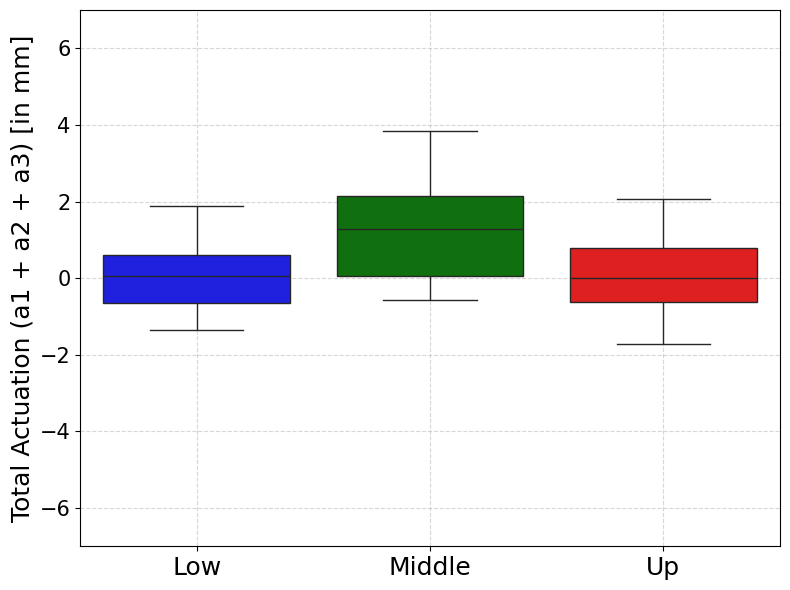

In [25]:
import seaborn as sns

# Create a boxplot
plt.figure(figsize=(8, 6))

sns.boxplot(data=row_sums, orient='v', palette=['blue', 'green', 'red'])
plt.xticks([0, 1, 2], ['Low', 'Middle', 'Up'], fontsize=18)

# increase size of values 
plt.yticks(fontsize=15)
# plt.title('Total Actuation (a1 + a2 + a3) by Section (3 inputs) - absolute difference')
plt.ylabel('Total Actuation (a1 + a2 + a3) [in mm]', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.5)
# Show in rnage of values
plt.ylim(-7, 7)
plt.tight_layout()
plt.show()

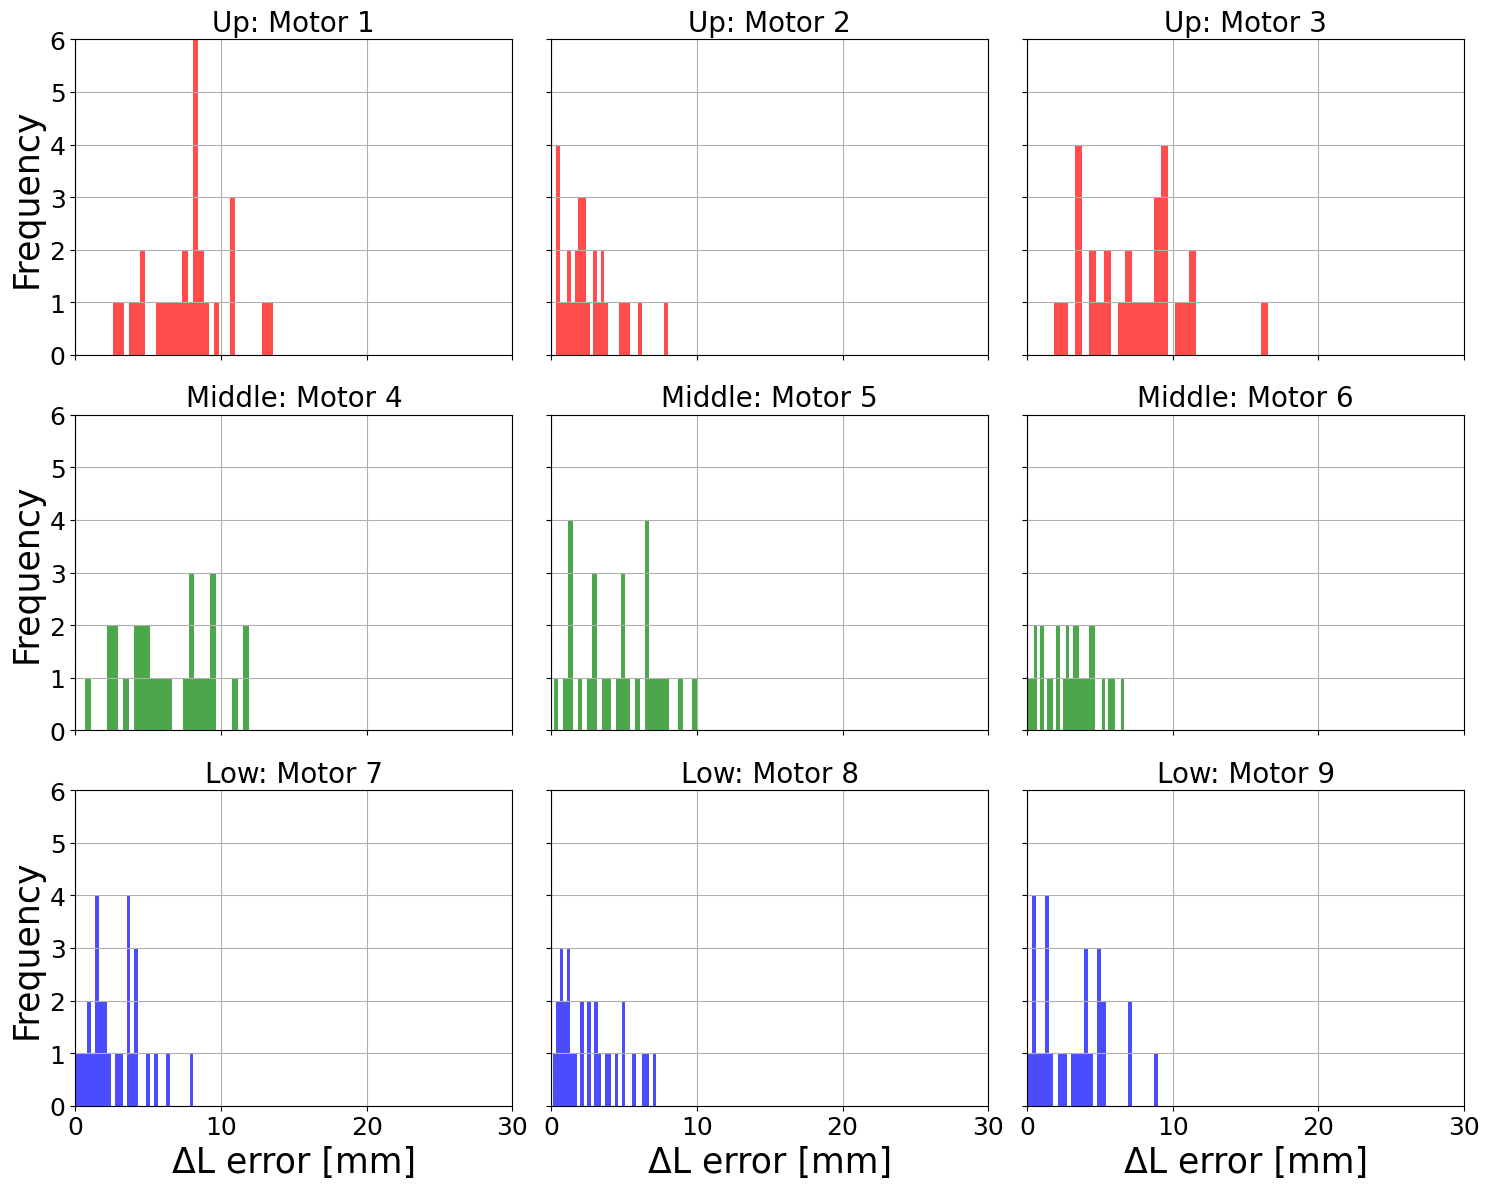

In [26]:
# Convert residuals to delta L values
residuals = diff.reshape(-1, 9)

diff_deltaL = residuals * 0.01534

fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)

# Define new order: up → middle → low
group_labels = ['Up', 'Middle', 'Low']
group_colors = ['red', 'green', 'blue']

column_indices = [6, 7, 8, 3, 4, 5, 0, 1, 2]

for plot_idx, col_idx in enumerate(column_indices):
    i = plot_idx // 3  # row
    j = plot_idx % 3   # col
    k = plot_idx + 1   # motor number
    ax = axes[i, j]
    
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 6)
    ax.hist(diff_deltaL[:, col_idx], bins=30, alpha=0.7, color=group_colors[i])
    
    group = group_labels[i]
    ax.set_title(f"{group}: Motor {k}", fontsize=20)
    ax.tick_params(axis='both', labelsize=18)

    
    # X-label only on bottom row
    if i == 2:
        ax.set_xlabel("ΔL error [mm]", fontsize=25)

    # Y-label only on first column
    if j == 0:
        ax.set_ylabel("Frequency", fontsize=25)
    
    ax.axvline(0, color='red', linestyle='--')
    ax.grid(True)

plt.tight_layout()
plt.show()


These numbers correspond to the **difference** of number of ticks. 
As our pulley diameter D = 20 mmm --> circumference C = pi * 20 mm = 62.83 mm/rev

Our dynamixel has a resolution of 12-bit: 4096 ticks/revolution, this means 4096 ticks ==> 62.83 mm
Each tick corresponds to:
62.83/4096 = **0.01534 mm/tick**

So for example, difference of 500 ticks corresponds to:
deltaL = 500 * 0.01534 mm = *7.67 mm*
of movement of cable. 